In [51]:
import torch 
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

In [76]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Set seed for reproducibility
random.seed(42)

# List all image paths
all_images = [os.path.join("./data/CelebA", img) for img in os.listdir("./data/CelebA") if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle and split
random.shuffle(all_images)
split_ratio = 0.8
split_index = int(split_ratio * len(all_images))
train_images = all_images[:split_index]
test_images = all_images[split_index:]

image_size = 128
batch_size = 256

# Define transform
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_images, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomImageDataset(test_images, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

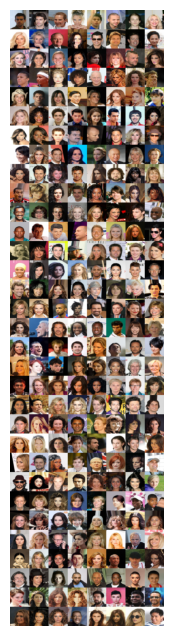

In [77]:
faces = next(iter(train_loader))

grid = torchvision.utils.make_grid(faces, nrow=8, padding=0, scale_each=True)

fig = plt.figure(figsize=(16,8))
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

Add noise and visualize one sample

In [78]:
def get_noised(image: torch.Tensor, T: int):
    """Return the lsit of denoised image."""
    images = []
    
    for t in range(T):
        # get alpha
        alpha = 0.5 * (1 - np.cos(np.pi * t / T))
        
        # add it to original image
        noised_image = image * (1 - alpha) +  alpha * torch.randn_like(image)
        
        # append it to list of noised images
        images.append(noised_image)
    
    return images

(-0.5, 127.5, 127.5, -0.5)

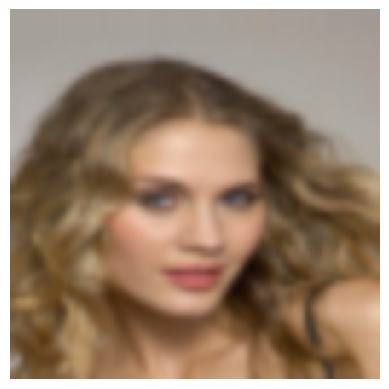

In [79]:
image = train_dataset[250]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')

Add noise until completely gone

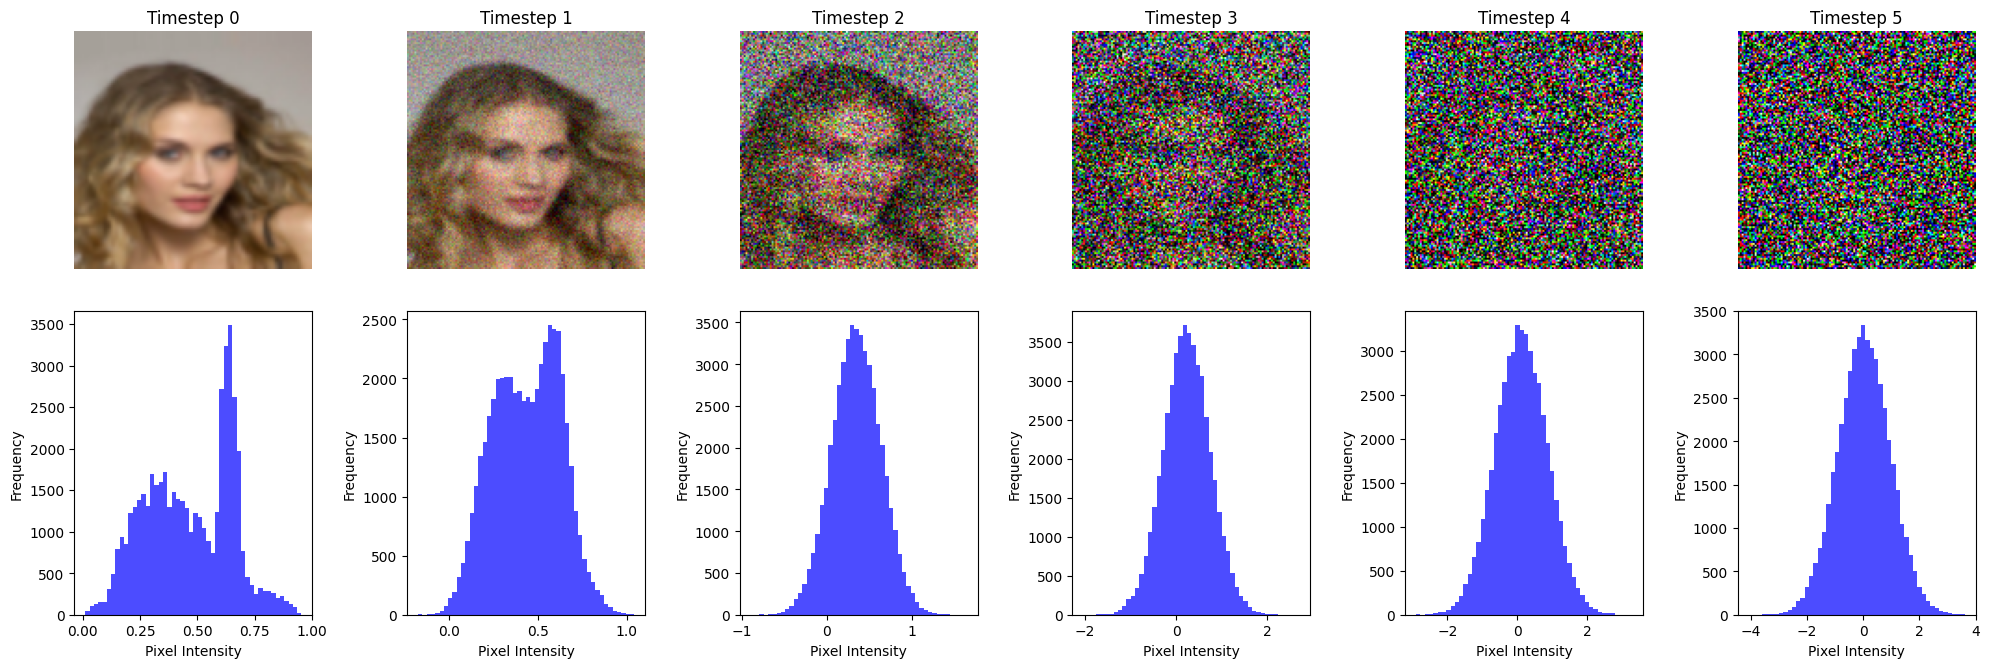

In [80]:
T = 6
noised_images = get_noised(image, T)

plt.figure(figsize=(20, 7))
for i in range(T):
    # Plot the noised image
    plt.subplot(2, T, i + 1)
    plt.imshow(noised_images[i].permute(1, 2, 0).clamp(0, 1))
    plt.axis('off')
    plt.title(f'Timestep {i}')

    # Plot the histogram
    plt.subplot(2, T, i + T + 1)
    plt.hist(noised_images[i].flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Encoder with VGG19 backbone

In [81]:
class VGGEncoder(nn.Module):
    def __init__(self):
        super(VGGEncoder, self).__init__()
        
        # Load pre-trained VGG-16 model without the final fully connected layers (features only)
        self.encoder = models.vgg16(
            pretrained=True, 
            weights=torchvision.models.vgg.VGG11_Weights
        ).features
        
        # Freeze the parameters
        for param in self.encoder.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.encoder(x)

Decoder (Generator)

In [82]:
class VGGDecoder(nn.Module):
    def __init__(self):
        super(VGGDecoder, self).__init__()

        # Decoder blocks
        self.decoder = nn.Sequential(
            self.decoder_block(512, 512),  # Input: 512x4x4,   Output: 512x8x8
            self.decoder_block(512, 256),  # Input: 512x6x6,   Output: 256x16x16
            self.decoder_block(256, 128),  # Input: 256x12x12, Output: 128x32x32
            self.decoder_block(128, 64),   # Input: 128x24x24, Output: 64x64x64
            self.decoder_block(64, 3),     # Input: 64x48x48,  Output: 3x128x128
            self.decoder_block(3, 3, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(3, 3, 1),
            nn.Sigmoid(),
        )

    def decoder_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.SiLU(True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.decoder(x)

Encapsulating a VAE

In [83]:
class VAE(nn.Module):
    def __init__(self, latent_dim=512, device="cpu"):
        super(VAE, self).__init__()

        self.device = device
        self.latent_dim = latent_dim
        
        # Use the VGG features as the encoder and decoder 
        self.encoder = VGGEncoder()

        # Latent layers
        self.fc_mu = nn.Linear(512*4*4, self.latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, self.latent_dim)
        self.bottle_neck = nn.Linear(self.latent_dim, 512*4*4)

        self.decoder = VGGDecoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std).to(self.device)

        z = mu + eps * std
        return z

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Flatten the encoder output
        x = torch.flatten(x, start_dim=-3)

        # Latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decoder
        z = self.bottle_neck(z)     
        x = torch.unflatten(z, dim=1, sizes=(512, 4, 4))
        x_recon = self.decoder(x)

        return x_recon, mu, logvar

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(device=device)
model.to(device)

c:\Users\24793\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VAE(
  (encoder): VGGEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

Weighted VAE Loss : Reconstruction (MSE) + KL divergence


In [85]:
class VAELoss(nn.Module):
    def __init__(self, reconstruction_weight=10, kl_weight=1):
        super(VAELoss, self).__init__()
        self.reconstruction_weight = reconstruction_weight
        self.kl_weight = kl_weight

    def forward(self, recon_x, x, mu, logvar):
        # Compute reconstruction loss (mean squared error)
        reconstruction_loss = nn.MSELoss(reduction='mean')(recon_x, x)

        # Compute KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss /= x.size(0)  # Average over batch

        # Total weighted loss
        loss = self.reconstruction_weight * reconstruction_loss + self.kl_weight * kl_loss

        return loss

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = VAE(device=device)
model.to(device)

VAE(
  (encoder): VGGEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [87]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images in train_loader:
        images = images.to(device)
        
        # Forward pass
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training Complete!")

Epoch [1/100], Loss: 49.3274
Epoch [2/100], Loss: 50.8553
Epoch [3/100], Loss: 49.9460


KeyboardInterrupt: 

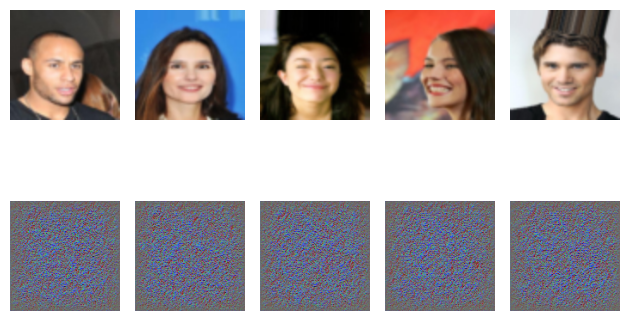

In [74]:
import matplotlib.pyplot as plt
num_images = 5

for i in range(num_images):
    image = train_dataset[i]

    plt.subplot(2, num_images, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(2, num_images, num_images+i+1)
    pred = model(image.unsqueeze(0).to("cuda"))[0].cpu()[0].detach().permute(1, 2, 0).numpy()
    plt.imshow(pred)
    plt.axis('off')

plt.tight_layout()
plt.show()